**Alzimer disease detection**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np

def grey2rgb(image):
    return np.stack((image,)*3, axis=-1)

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
# Load Train and Validation Datasets
# train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\train',
#                                                    target_size = (224,224),
#                                                    class_mode = 'categorical',
#                                                    subset = 'training',
#                                                    batch_size = 128)

# valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\train',
#                                                   target_size = (224,224),
#                                                   class_mode = 'categorical',
#                                                   subset = 'validation',
#                                                   batch_size = 128)

train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\dataset\Dataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\dataset\Dataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [9]:
# Model Initialization
# DenseNet169 Model
densenet_base = DenseNet169(input_shape=(224, 224, 3), 
                            include_top=False, 
                            weights="imagenet")


In [11]:
# ResNet50 Model
resnet_base = ResNet50(input_shape=(224, 224, 3), 
                       include_top=False, 
                       weights="imagenet")



In [13]:
# Freezing Layers for both models
for layer in densenet_base.layers:
    layer.trainable = False
    
for layer in resnet_base.layers:
    layer.trainable = False


In [15]:
# Concatenate DenseNet and ResNet feature maps
input_layer = Input(shape=(224, 224, 3))

densenet_features = densenet_base(input_layer)
densenet_features = GlobalAveragePooling2D()(densenet_features)

resnet_features = resnet_base(input_layer)
resnet_features = GlobalAveragePooling2D()(resnet_features)

In [17]:
# Combine features
combined = concatenate([densenet_features, resnet_features])

In [19]:
# Adding Fully Connected Layers
x = Dropout(0.5)(combined)
x = BatchNormalization()(x)
x = Dense(2048, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

In [21]:
# Final model
model = Model(inputs=input_layer, outputs=output_layer)

In [23]:
# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ input_layer_2[0]… │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3712)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3712)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3712)      │     14,848 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  7,604,224 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  2,098,176 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │      4,100 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,964,228 (175.34 MB)

 Trainable params: 9,720,068 (37.08 MB)

 Non-trainable params: 36,244,160 (138.26 MB)

In [25]:
# Model Compile 
OPT = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name='auc')],
              optimizer=OPT)

In [27]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure the directory exists
save_dir = os.path.join(os.getcwd(), '.keras')  # This will create the path './.keras'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  # Create the directory if it doesn't exist

# Filepath for saving the best weights
filepath = os.path.join(save_dir, 'best_weights.keras')  # Change .hdf5 to .keras

earlystopping = EarlyStopping(monitor='val_auc', 
                              mode='max', 
                              patience=15, 
                              verbose=1)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_auc', 
                             mode='max', 
                             save_best_only=True, 
                             verbose=1)

callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Training
model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=10,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.7395 - loss: 1.4763 
Epoch 1: val_auc improved from -inf to 0.66008, saving model to C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\.keras\best_weights.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1013s 24s/step - auc: 0.7402 - loss: 1.4749 - val_auc: 0.6601 - val_loss: 1.3508
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.7939 - loss: 1.2434 
Epoch 2: val_auc improved from 0.66008 to 0.72017, saving model to C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\.keras\best_weights.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 995s 24s/step - auc: 0.7939 - loss: 1.2428 - val_auc: 0.7202 - val_loss: 1.1945
Epoch 3/10
13/41 ━━━━━━━━━━━━━━━━━━━━ 8:02 17s/step - auc: 0.8072 - loss: 1.1102

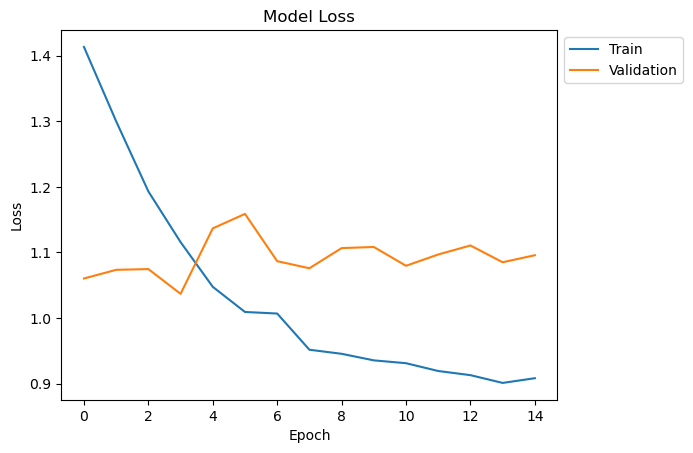

In [31]:
# Summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

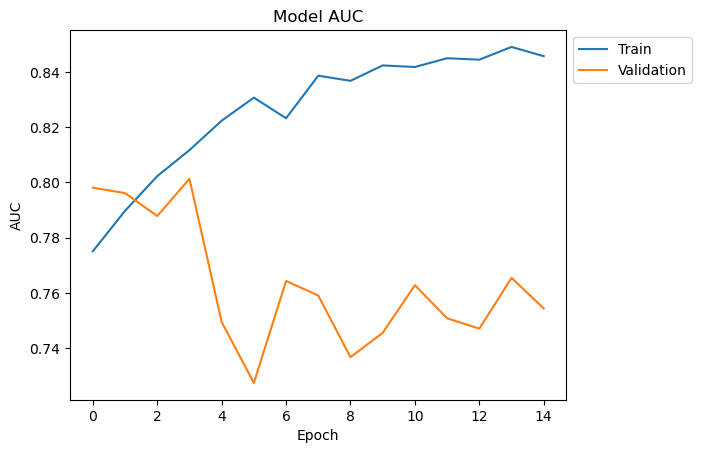

In [33]:
# Summarize history for AUC
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


In [35]:
# Test Data 
# test_dataset  = test_datagen.flow_from_directory(directory = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\test',
#                                                  target_size = (224,224),
#                                                  class_mode = 'categorical',
#                                                  batch_size = 128)

Found 1279 images belonging to 4 classes.


In [37]:
# Evaluating Loss and AUC
# model.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 168s 17s/step - auc: 0.8492 - loss: 0.9237


[0.9042779803276062, 0.8541699647903442]

10/10 ━━━━━━━━━━━━━━━━━━━━ 192s 18s/step


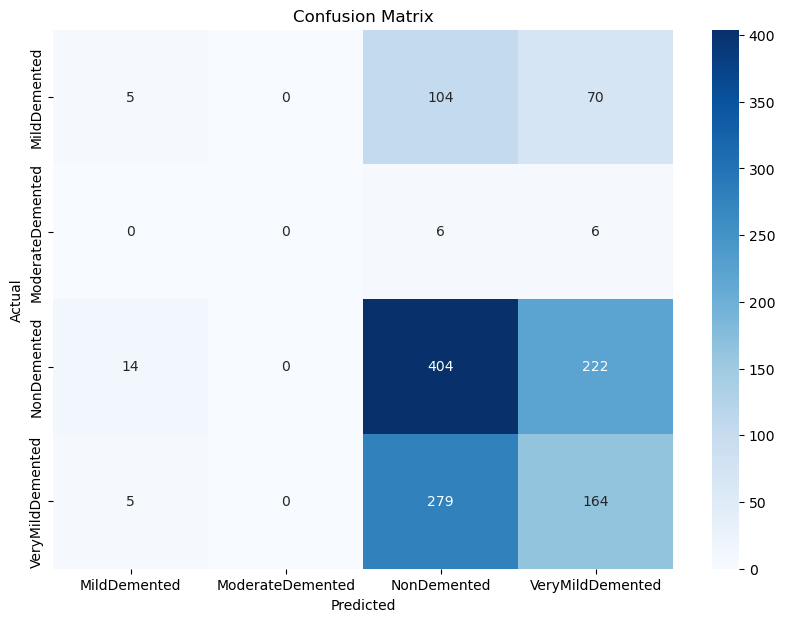

                  precision    recall  f1-score   support

    MildDemented       0.21      0.03      0.05       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.51      0.63      0.56       640
VeryMildDemented       0.35      0.37      0.36       448

        accuracy                           0.45      1279
       macro avg       0.27      0.26      0.24      1279
    weighted avg       0.41      0.45      0.42      1279



D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
#Printing Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict the labels of the test dataset
test_labels = test_dataset.classes
predictions = model.predict(test_dataset, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_indices, yticklabels=test_dataset.class_indices)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels, predicted_labels, target_names=test_dataset.class_indices.keys()))


In [151]:
#Predicting Stage from a Single MRI Image
# Load and preprocess a single MRI image
# image_path = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\test\NonDemented\26 (63).jpg'  # Non Demented
# image_path = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\test\MildDemented\26 (24).jpg' #Mild Demented
# image_path = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\test\ModerateDemented\28.jpg' #Moderate Demented
image_path = r'C:\Users\shiva_tfov3bz\OneDrive\Documents\mini project\input\Alzheimer_s Dataset\test\VeryMildDemented\26 (45).jpg' #Very Mild Demented
# Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input dimensions
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale

# Predict the class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Print the predicted stage of the patient
class_labels = list(train_dataset.class_indices.keys())
print(f'The patient is predicted to be in the stage: {class_labels[predicted_class[0]]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
The patient is predicted to be in the stage: VeryMildDemented
